In [1]:
!apt-get install exiftool
!pip install git+https://github.com/detecttechnologies/thermal_base.git@main

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libposix-strptime-perl libsombok3
  libunicode-linebreak-perl
Suggested packages:
  libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl
  libposix-strptime-perl libsombok3 libunicode-linebreak-perl
0 upgraded, 6 newly installed, 0 to remove and 39 not upgraded.
Need to get 3,395 kB of archives.
After this operation, 20.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libarchive-zip-perl all 1.60-1ubuntu0.1 [84.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libimage-exiftool-perl all 10.80-1ubuntu0.1 [3,147 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [2]:
import matplotlib.pyplot as plt
from thermal_base import ThermalImage
import numpy as np
import pandas as pd 

In [3]:
def read_image(image_path):
    """This function transforms a DJI Mavic 2 Enterprise Due drone image into a numpy array.
    input: JPG thermal image path.
    output: temperature numpy array."""

    # Uses the library thermal_base to process the DJI image.
    # (https://github.com/detecttechnologies/thermal_base)

    image = ThermalImage(image_path=image_path, camera_manufacturer="dji")

    thermal_np = image.thermal_np           # The temperature matrix as a np array

    return thermal_np

In [4]:
loc = "/content/drive/MyDrive/Grad/Research/Data/1214/thermal/DJI_0"
all_temp = {}
missing_images = [408, 410, 412, 414]
for i in range(354, 473, 2):
  image_path = str(loc)+ str(i) +".JPG"
  # print(image_path)
  if i in missing_images:
    pass
  else:
    image = read_image(image_path)
    for r in range(image.shape[0]):
      for c in range(image.shape[1]):
        temp = image[r][c]
        if temp in all_temp:
          all_temp[temp] = all_temp[temp] + 1
        else:
          all_temp[temp] = 1

In [ ]:
all_temp

In [6]:
all_temp_df = pd.DataFrame.from_dict(all_temp, orient='index', columns=['Temperature']) 

xvals = all_temp_df.index.values.tolist()
yvals = list(all_temp_df['Temperature'])

In [7]:
# len(xvals)
len(yvals)

778

In [ ]:
plt.figure()
plt.xlabel("Temperature (˚C)")
plt.ylabel("Number of of Pixels")
plt.hist(x= xvals, y=yvals, bins=len(yvals))
plt.show()

In [ ]:
all_temp_df

In [10]:
# all_temp_df_2 = pd.DataFrame.from_dict([all_temp]) 

# pd.DataFrame.hist(all_temp_df_2)

In [13]:
"""Thermal base module."""
import io
import json
import subprocess as sp
import sys, os, platform
import requests, zipfile
from pathlib import Path
from threading import Thread

import cv2 as cv
import numpy as np
from logzero import logger
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

from thermal_base import flyr_unpack
from thermal_base import utils as ThermalImageHelpers

In [14]:
meta = {
            "Emissivity": 1.0,
            "ObjectDistance": 1,
            "AtmosphericTemperature": 20,
            "ReflectedApparentTemperature": 20,
            "IRWindowTemperature": 20,
            "IRWindowTransmission": 1,
            "RelativeHumidity": 50,
            "PlanckR1": 21106.77,
            "PlanckB": 1501,
            "PlanckF": 1,
            "PlanckO": -7340,
            "PlanckR2": 0.012545258,
        }

In [17]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 439 kB/s 


In [22]:
import rasterio as rio
import numpy.ma as ma

In [26]:
with rio.open("/content/drive/MyDrive/Grad/Research/Data/1214/thermal/Orthomosaic.tif") as img:
        raw_sensor_np = img.read(1)

In [23]:
# raw_sensor_np = ma.masked_less_equal(raw_sensor_np, 0)

In [34]:
print(raw_sensor_np)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [52]:
def sensor_vals_to_temp(
    raw,
    Emissivity=1.0,
    ObjectDistance=1,
    AtmosphericTemperature=20,
    ReflectedApparentTemperature=20,
    IRWindowTemperature=20,
    IRWindowTransmission=1,
    RelativeHumidity=50,
    PlanckR1=21106.77,
    PlanckB=1501,
    PlanckF=1,
    PlanckO=-7340,
    PlanckR2=0.012545258,
    **kwargs,
    ):
    """Convert raw values from the thermographic sensor sensor to temperatures in °C. Tested for Flir cams."""
    # this calculation has been ported to python from https://github.com/gtatters/Thermimage/blob/master/R/raw2temp.R
    # a detailed explanation of what is going on here can be found there

    # constants
    ATA1 = 0.006569
    ATA2 = 0.01262
    ATB1 = -0.002276
    ATB2 = -0.00667
    ATX = 1.9

    # transmission through window (calibrated)
    emiss_wind = 1 - IRWindowTransmission
    refl_wind = 0
    # transmission through the air
    h2o = (RelativeHumidity / 100) * np.exp(
        1.5587
        + 0.06939 * (AtmosphericTemperature)
        - 0.00027816 * (AtmosphericTemperature) ** 2
        + 0.00000068455 * (AtmosphericTemperature) ** 3
    )
    tau1 = ATX * np.exp(-np.sqrt(ObjectDistance / 2) * (ATA1 + ATB1 * np.sqrt(h2o))) + (1 - ATX) * np.exp(
        -np.sqrt(ObjectDistance / 2) * (ATA2 + ATB2 * np.sqrt(h2o))
    )
    tau2 = ATX * np.exp(-np.sqrt(ObjectDistance / 2) * (ATA1 + ATB1 * np.sqrt(h2o))) + (1 - ATX) * np.exp(
        -np.sqrt(ObjectDistance / 2) * (ATA2 + ATB2 * np.sqrt(h2o))
    )
    # radiance from the environment
    raw_refl1 = PlanckR1 / (PlanckR2 * (np.exp(PlanckB / (ReflectedApparentTemperature + 273.15)) - PlanckF)) - PlanckO
    raw_refl1_attn = (1 - Emissivity) / Emissivity * raw_refl1  # Reflected component

    raw_atm1 = (
        PlanckR1 / (PlanckR2 * (np.exp(PlanckB / (AtmosphericTemperature + 273.15)) - PlanckF)) - PlanckO
    )  # Emission from atmosphere 1
    raw_atm1_attn = (1 - tau1) / Emissivity / tau1 * raw_atm1  # attenuation for atmospheric 1 emission

    raw_wind = (
        PlanckR1 / (PlanckR2 * (np.exp(PlanckB / (IRWindowTemperature + 273.15)) - PlanckF)) - PlanckO
    )  # Emission from window due to its own temp
    raw_wind_attn = (
        emiss_wind / Emissivity / tau1 / IRWindowTransmission * raw_wind
    )  # Componen due to window emissivity

    raw_refl2 = (
        PlanckR1 / (PlanckR2 * (np.exp(PlanckB / (ReflectedApparentTemperature + 273.15)) - PlanckF)) - PlanckO
    )  # Reflection from window due to external objects
    raw_refl2_attn = (
        refl_wind / Emissivity / tau1 / IRWindowTransmission * raw_refl2
    )  # component due to window reflectivity

    raw_atm2 = (
        PlanckR1 / (PlanckR2 * (np.exp(PlanckB / (AtmosphericTemperature + 273.15)) - PlanckF)) - PlanckO
    )  # Emission from atmosphere 2
    raw_atm2_attn = (
        (1 - tau2) / Emissivity / tau1 / IRWindowTransmission / tau2 * raw_atm2
    )  # attenuation for atmospheric 2 emission

    raw_obj = (
        raw / Emissivity / tau1 / IRWindowTransmission / tau2
        - raw_atm1_attn
        - raw_atm2_attn
        - raw_wind_attn
        - raw_refl1_attn
        - raw_refl2_attn
    )
    val_to_log = PlanckR1 / (PlanckR2 * (raw_obj + PlanckO)) + PlanckF
    # if any(val_to_log.ravel() < 0):
    #     raise Exception("Image seems to be corrupted")
    # temperature from radiance
    # return PlanckB / np.log(val_to_log) - 273.15
    val_to_log = ma.log(val_to_log).filled(0)
    return PlanckB / ma.masked_less_equal(val_to_log, 0) - 273.15

In [53]:
thermal_np = sensor_vals_to_temp(raw_sensor_np, **meta)

In [54]:
thermal_np

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float64)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


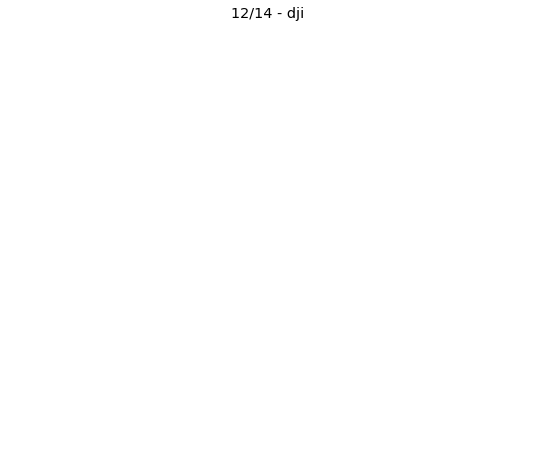

In [55]:
# plot the image
fig, ax = plt.subplots(figsize=(10, 8))
im = plt.imshow(thermal_np, interpolation='nearest')
# ep.colorbar(im)
ax.set(title="12/14 - dji")
ax.set_axis_off()
plt.show()